In [1]:
%pip install -q --upgrade keras tensorflow setuptools scikit-learn segmentation-models matplotlib opencv-python seaborn keras_tuner
print("Successfully installed required packages.")

Note: you may need to restart the kernel to use updated packages.


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

### Run the following code in a terminal

```bash
pip install kaggle
kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels
unzip chest-xray-masks-and-labels.zip
unzip tuberculosis-tb-chest-xray-dataset.zip
rm -rf data
mv Lung\ Segmentation segmentation_data
cd segmentation_data
rm -rf ClinicalReadings
rm NLM-ChinaCXRSet-ReadMe.docx
rm NLM-MontgomeryCXRSet-ReadMe.pdf
mv CXR_png images

cd ..
mv TB_Chest_Radiography_Database data
```

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

split_dir = './data/split'

def split_dataset(base_split_dir='./data/split', normal_dir='./data/Normal', tb_dir='./data/Tuberculosis'):
    train_split = 'train'
    test_split = 'test'
    splits = [train_split, test_split]
    normal_class = 'normal'
    tb_class = 'tuberculosis'
    classes = [normal_class, tb_class]

    normal_files = [f for f in os.listdir(normal_dir) if os.path.isfile(os.path.join(normal_dir, f))]
    tb_files = [f for f in os.listdir(tb_dir) if os.path.isfile(os.path.join(tb_dir, f))]

    if os.path.exists(base_split_dir):
        print("Removing existing dataset")
        # If the split directory exists, remove it and so it can be regenerated
        shutil.rmtree(base_split_dir)

    # Split the data into training, test sets
    # The validation set will be created from the training set at a later stage
    train_normal, test_normal = train_test_split(normal_files, test_size=0.1)
    train_tb, test_tb = train_test_split(tb_files, test_size=0.1)

    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(base_split_dir, split, cls), exist_ok=True)

    # Function to copy files to their respective directories
    def copy_files(file_list, dst_dir):
        for file in file_list:
            src_dir = normal_dir if file in normal_files else tb_dir
            shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

    print("Copying train normal set...")
    copy_files(train_normal, os.path.join(base_split_dir, train_split, normal_class))
    print("Copying test normal set...")
    copy_files(test_normal, os.path.join(base_split_dir, test_split, normal_class))

    print("Copying train normal set...")
    copy_files(train_tb, os.path.join(base_split_dir, train_split, tb_class))
    print("Copying test normal set...")
    copy_files(test_tb, os.path.join(base_split_dir, test_split, tb_class))

split_dataset(base_split_dir=split_dir)

Removing existing dataset
Copying train normal set...
Copying test normal set...
Copying train normal set...
Copying test normal set...


In [4]:
import keras

training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.
Found 420 files belonging to 2 classes.


In [5]:
no_weighting_model = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(16, (7, 7), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation='sigmoid'),
])

no_weighting_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        'precision',
        'recall',
        keras.metrics.F1Score(name="f1_score"),
        keras.metrics.AUC(num_thresholds=3)
    ]
)

no_weighting_history = no_weighting_model.fit(train_dataset, epochs=10, validation_data=validation_dataset)

no_weighting_results = no_weighting_model.evaluate(test)
no_weighting_predictions = no_weighting_model.predict(test)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 73s 672ms/step - accuracy: 0.8150 - auc: 0.5005 - f1_score: 0.2959 - loss: 12.6641 - precision: 0.1748 - recall: 0.0221 - val_accuracy: 0.8492 - val_auc: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6587 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 73s 680ms/step - accuracy: 0.8310 - auc: 0.5000 - f1_score: 0.2890 - loss: 0.6532 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_auc: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6280 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 71s 667ms/step - accuracy: 0.8307 - auc: 0.5000 - f1_score: 0.2895 - loss: 0.6254 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_auc: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6010 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 73s 680ms/step - accuracy: 0.8280 - auc: 0.5000 - f1_score

In [6]:
import keras

weighting_model = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(16, (7, 7), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dropout(0.6),
    keras.layers.Dense(1, activation='sigmoid'),
])

weighting_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        'precision',
        'recall',
        keras.metrics.F1Score(name="f1_score"),
        keras.metrics.AUC(num_thresholds=3)
    ]
)

weighting_history = weighting_model.fit(
    train_dataset,
    epochs=10,
    validation_data=validation_dataset,
    class_weight={0: 0.2, 1: 1}
)

weighting_results = weighting_model.evaluate(test)
weighting_predictions = weighting_model.predict(test)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 72s 667ms/step - accuracy: 0.2167 - auc_1: 0.5030 - f1_score: 0.2949 - loss: 2.7624 - precision: 0.1832 - recall: 0.9390 - val_accuracy: 0.1508 - val_auc_1: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6947 - val_precision: 0.1508 - val_recall: 1.0000
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 72s 675ms/step - accuracy: 0.1705 - auc_1: 0.5000 - f1_score: 0.2913 - loss: 0.2332 - precision: 0.1705 - recall: 1.0000 - val_accuracy: 0.1508 - val_auc_1: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6953 - val_precision: 0.1508 - val_recall: 1.0000
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 73s 680ms/step - accuracy: 0.1652 - auc_1: 0.5000 - f1_score: 0.2834 - loss: 0.2303 - precision: 0.1652 - recall: 1.0000 - val_accuracy: 0.1508 - val_auc_1: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6953 - val_precision: 0.1508 - val_recall: 1.0000
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 73s 680ms/step - accuracy: 0.1691 - auc_1: 0.5000 - f1_score: 0.2891 - loss: 0.2324 - p

2024-07-22 15:05:33.692908: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


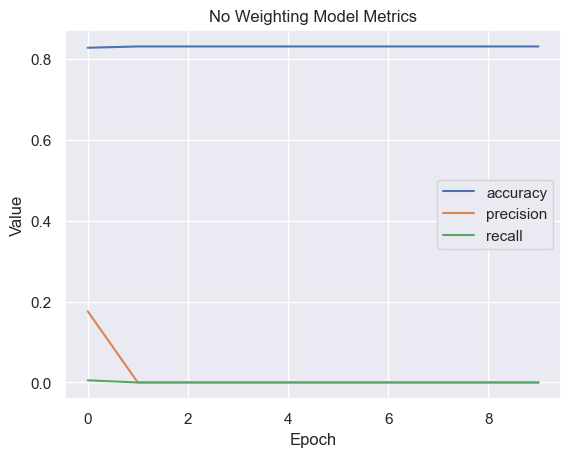

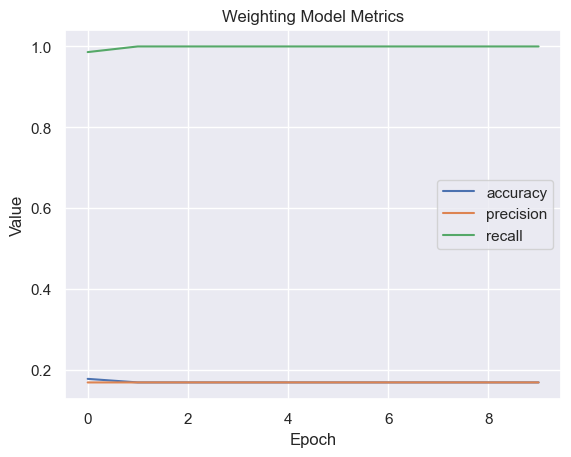

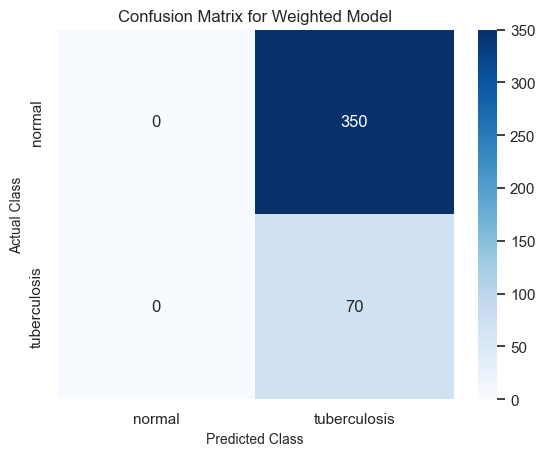

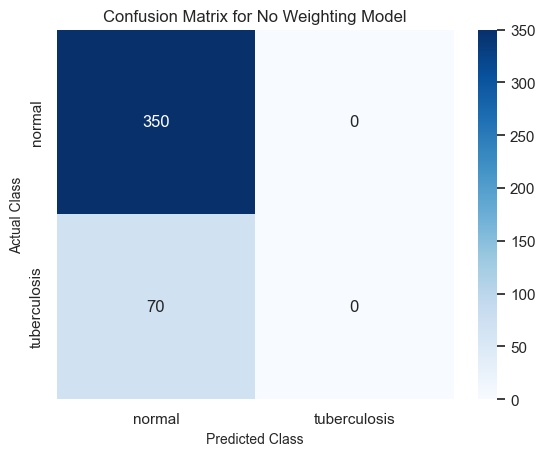

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

sns.set_theme("notebook")

true_y = np.concatenate([y for _, y in test], axis=0).astype(int)
weighted_output = (weighting_predictions > 0.5).astype(int)
no_weighting_output = (no_weighting_predictions > 0.5).astype(int)

# plot the metrics using seaborn
def plot_metrics(history, metrics, title=None):
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

plot_metrics(no_weighting_history, ['accuracy', 'precision', 'recall'], title="No Weighting Model Metrics")
plot_metrics(weighting_history, ['accuracy', 'precision', 'recall'], title="Weighting Model Metrics")

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Class', fontsize=10)
    plt.ylabel('Actual Class', fontsize=10)
    plt.title(title, fontsize=12)
    plt.show()

plot_confusion_matrix(true_y, weighted_output, ['normal', 'tuberculosis'], title='Confusion Matrix for Weighted Model')
plot_confusion_matrix(true_y, no_weighting_output, ['normal', 'tuberculosis'], title='Confusion Matrix for No Weighting Model')

In [9]:
import os

DATA_DIR = "./segmentation_data"
image_dir = os.path.join(DATA_DIR, "images")
mask_dir = os.path.join(DATA_DIR, "masks")

masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]
for mask in masks:
    if mask.endswith("_mask.png"):
        os.rename(os.path.join(mask_dir, mask), os.path.join(mask_dir, mask.replace("_mask", "")))

images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
for img in images:
    if os.path.isfile(os.path.join(mask_dir, img)):
        continue
    os.remove(os.path.join(image_dir, img))

# Split the dataset into training and validation sets
images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]

In [10]:
images = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
masks = [f for f in os.listdir(mask_dir) if os.path.isfile(os.path.join(mask_dir, f))]

train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.1)

if os.path.exists(os.path.join(DATA_DIR, "train")):
    print("Removing existing train dataset...")
    shutil.rmtree(os.path.join(DATA_DIR, "train"))

if os.path.exists(os.path.join(DATA_DIR, "val")):
    print("Removing existing validation dataset...")
    shutil.rmtree(os.path.join(DATA_DIR, "val"))

train_image_dir = os.path.join(DATA_DIR, "train", "images")
val_image_dir = os.path.join(DATA_DIR, "val", "images")
train_mask_dir = os.path.join(DATA_DIR, "train", "masks")
val_mask_dir = os.path.join(DATA_DIR, "val", "masks")

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(train_mask_dir, exist_ok=True)
os.makedirs(val_mask_dir, exist_ok=True)

def copy_files(file_list, src_dir, dst_dir):
    for file in file_list:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

print("Copying train images...")
copy_files(train_images, image_dir, train_image_dir)
print("Copying validation images...")
copy_files(val_images, image_dir, val_image_dir)
print("Copying train masks...")
copy_files(train_masks, mask_dir, train_mask_dir)
print("Copying validation masks...")
copy_files(val_masks, mask_dir, val_mask_dir)

Copying train images...
Copying validation images...
Copying train masks...
Copying validation masks...


In [11]:
import keras
import tensorflow as tf

train_masks_dir = os.path.join(DATA_DIR, "train", "masks")
train_images_dir = os.path.join(DATA_DIR, "train", "images")
val_masks_dir = os.path.join(DATA_DIR, "val", "masks")
val_images_dir = os.path.join(DATA_DIR, "val", "images")

train_masks = keras.utils.image_dataset_from_directory(
    train_masks_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

train_images = keras.utils.image_dataset_from_directory(
    train_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

val_masks = keras.utils.image_dataset_from_directory(
    val_masks_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

val_images = keras.utils.image_dataset_from_directory(
    val_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

train_dataset = tf.data.Dataset.zip((train_images, train_masks))
val_dataset = tf.data.Dataset.zip((val_images, val_masks))

train_dataset = train_dataset.map(lambda x, y: (x / 255.0, y / 255.0))
val_dataset = val_dataset.map(lambda x, y: (x / 255.0, y / 255.0))

Found 633 files.
Found 633 files.
Found 71 files.
Found 71 files.


In [12]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm

BACKBONE = 'resnet34'
early_stopper = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

base_model = sm.Unet(
    BACKBONE,
    encoder_weights='imagenet',
)

inp = keras.layers.Input(shape=(256, 256, 1))
l1 = keras.layers.Conv2D(3, (1, 1))(inp)
out = base_model(l1)

model = keras.models.Model(inp, out, name=base_model.name)

model.compile(
    keras.optimizers.Adam(learning_rate=0.001),
    loss=sm.losses.DiceLoss(),
    metrics=[sm.metrics.iou_score, sm.metrics.FScore],
)

history = model.fit(train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=[early_stopper]
)

Segmentation Models: using `tf.keras` framework.
Epoch 1/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 133s 3s/step - f1-score: 0.5906 - iou_score: 0.4300 - loss: 0.4094 - val_f1-score: 0.4476 - val_iou_score: 0.2884 - val_loss: 0.5544
Epoch 2/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 122s 3s/step - f1-score: 0.7707 - iou_score: 0.6277 - loss: 0.2293 - val_f1-score: 0.5593 - val_iou_score: 0.3884 - val_loss: 0.4372
Epoch 3/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - f1-score: 0.7837 - iou_score: 0.6447 - loss: 0.2163 - val_f1-score: 0.6860 - val_iou_score: 0.5225 - val_loss: 0.3137
Epoch 4/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - f1-score: 0.7865 - iou_score: 0.6485 - loss: 0.2135 - val_f1-score: 0.7480 - val_iou_score: 0.5989 - val_loss: 0.2587
Epoch 5/5
40/40 ━━━━━━━━━━━━━━━━━━━━ 123s 3s/step - f1-score: 0.7957 - iou_score: 0.6611 - loss: 0.2043 - val_f1-score: 0.7638 - val_iou_score: 0.6187 - val_loss: 0.2375


Found 96 files.
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 661ms/step


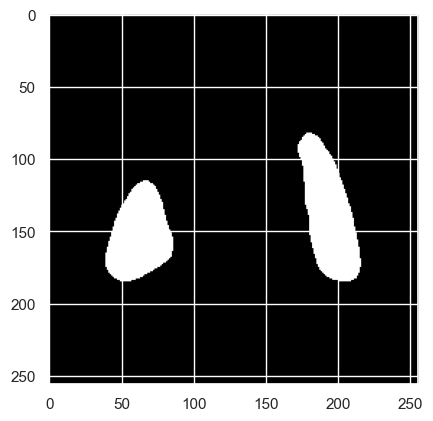

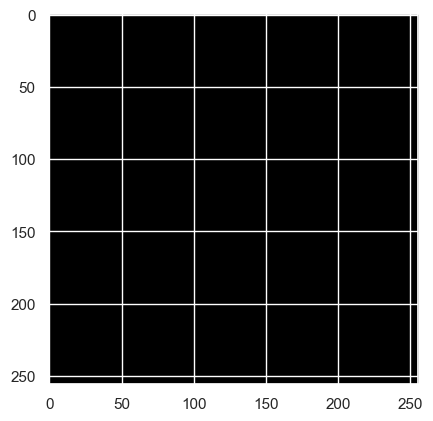

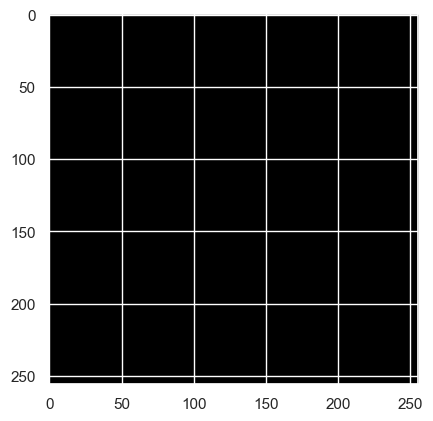

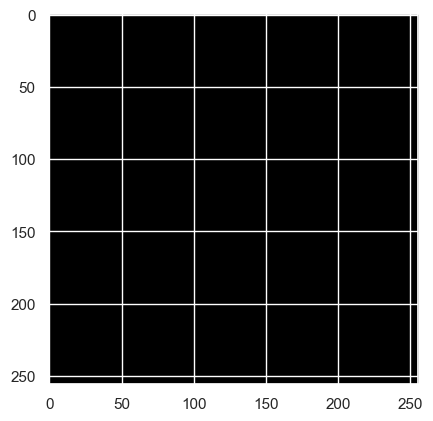

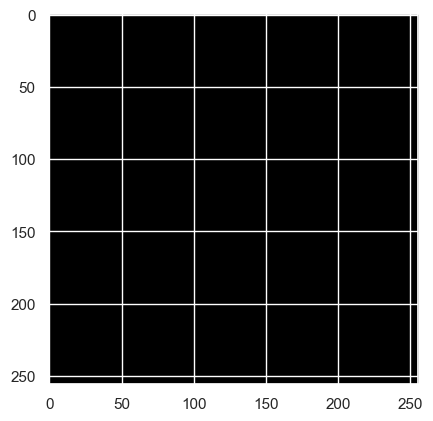

In [13]:
import numpy as np
import matplotlib.pyplot as plt

test_images_dir = os.path.join(DATA_DIR, "test")
test_images = keras.utils.image_dataset_from_directory(
    test_images_dir,
    label_mode=None,
    color_mode='grayscale',
    batch_size=16,
    image_size=(256, 256)
)

results = model.predict(test_images)
for i in range(5):
    pred = results[i]
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imshow(pred, cmap='gray')
    plt.show()


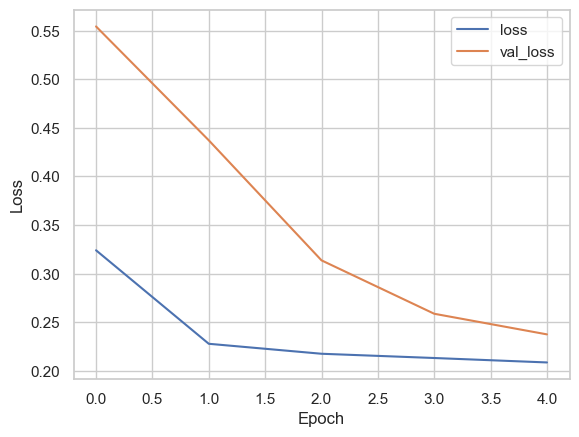

In [14]:
# plot the loss and validation loss using seaborn

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
test_filenames = os.listdir(test_images_dir)

if os.path.exists(os.path.join(DATA_DIR, "out")):
    print("Removing existing output directory...")
    shutil.rmtree(os.path.join(DATA_DIR, "out"))

os.makedirs(os.path.join(DATA_DIR, "out"), exist_ok=True)
out_dir = os.path.join(DATA_DIR, "out")
for pred, fn in zip(results, test_filenames):
    pred = np.squeeze(pred)
    pred = (pred > 0.5).astype(np.uint8)
    plt.imsave(os.path.join(out_dir, fn), pred, cmap="gray")

In [16]:
import cv2
import os
import numpy as np

overlayed_out = os.path.join(DATA_DIR, "overlayed_out")

os.makedirs(overlayed_out, exist_ok=True)

def overlay_mask_on_image(image, mask):
    mask = mask > 0.5
    overlay_image = np.zeros_like(image)
    overlay_image[mask] = image[mask]

    return overlay_image

for img_name in os.listdir(test_images_dir):
    img_path = os.path.join(test_images_dir, img_name)
    mask_path = os.path.join(out_dir, img_name)
    
    original_image = cv2.imread(img_path)
    original_image = cv2.resize(original_image, (256, 256))
    
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = mask / 255.0
    
    overlay_image = overlay_mask_on_image(original_image, mask)

    cv2.imwrite(os.path.join(overlayed_out, img_name), overlay_image)


## Developing the Classification Model

### Finding the optimal architecture
This will start with a Grid-Search approach, to find the general direction in which to move. Once that is done a human-directed approach will begin. At this stage it is purely about finding the optimal number of layers and neurons per layer.

At this stage the focus will be on the convolutional layers, while keeping the densely connected layers stable.

In [17]:
import tensorflow as tf
import keras_tuner

def build_model(hp, deterministic=True):
    if deterministic == True:
        tf.keras.utils.set_random_seed(1)

    conv_kernal_size = hp.Choice(name="conv_kernal_size", values=[7, 16, 32])
    pooling_size = hp.Choice(name="pooling_size", values=[2, 4, 8])

    model = keras.models.Sequential([
        keras.layers.InputLayer(shape=(256, 256, 3)),
        keras.layers.Conv2D(hp.Choice(name="conv_filters", values=[16, 24, 36]), (conv_kernal_size, conv_kernal_size), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(pooling_size, pooling_size)),
        keras.layers.Flatten(),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(50, activation='relu'),
        keras.layers.Dense(5, activation='relu'),
        keras.layers.Dropout(0.6),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            'precision',
            'recall',
            keras.metrics.F1Score(name="f1_score"),
            keras.metrics.AUC(num_thresholds=3)
        ]
    )

    return model

In [18]:
training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    min_delta=0.01,
    mode="auto",
)

tuner = keras_tuner.GridSearch(
    build_model,
    objective='val_loss',
    project_name="model_same_no_layers"
)

tuner.search(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=[cb])

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.
Found 420 files belonging to 2 classes.
Reloading Tuner from ./model_same_no_layers/tuner0.json


## Poor results

The grid search yielded very poor results, continuing with a human-directed-search to get to a better starting ground.

In [20]:
training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

human_dir_1 = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

human_dir_1.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        'precision',
        'recall',
        keras.metrics.F1Score(name="f1_score"),
        keras.metrics.AUC(num_thresholds=3)
    ]
)

history = human_dir_1.fit(train_dataset, epochs=100, validation_data=validation_dataset)

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.
Found 420 files belonging to 2 classes.
Epoch 1/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 108s 980ms/step - accuracy: 0.8010 - auc_3: 0.4967 - f1_score: 0.2874 - loss: 97.7269 - precision: 0.1348 - recall: 0.0341 - val_accuracy: 0.8492 - val_auc_3: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6580 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 104s 971ms/step - accuracy: 0.8310 - auc_3: 0.5000 - f1_score: 0.2890 - loss: 0.6525 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_auc_3: 0.5000 - val_f1_score: 0.2621 - val_loss: 0.6272 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
107/107 ━━━━━━━━━━━━━━━━━━━━ 104s 967ms/step - accuracy: 0.8307 - auc_3: 0.5000 - f1_score: 0.2895 - loss: 0.6246 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8492 - val_auc_3: 0.5000 - val_f1_score: 0.2621 - val_lo

## Still a lack of power

Attempt to increase the number of convolutional & max pooling layer pairs.

In [22]:
import keras

split_dir = './data/split'

training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

human_dir_3 = keras.Sequential([
    keras.layers.InputLayer(shape=(256, 256, 3)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
])

human_dir_3.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        'precision',
        'recall',
        keras.metrics.F1Score(name="f1_score"),
        keras.metrics.AUC(num_thresholds=3)
    ]
)

history = human_dir_3.fit(train_dataset, epochs=100, validation_data=validation_dataset)

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.
Found 420 files belonging to 2 classes.
Epoch 1/100
  1/107 ━━━━━━━━━━━━━━━━━━━━ 1:50:13 62s/step - accuracy: 0.1875 - auc_5: 0.5000 - f1_score: 0.3158 - loss: 14.5769 - precision: 0.1875 - recall: 1.0000

: 

## Increasing Layers

Looking at the evaluation performed above there is still a precision of 0 in all cases. However looking at the top results, we can see that more power generally performed better than less power.

## Next Steps

In the next steps I will look at using another existing architecture which was used for [pneumonia binary classification](https://ieeexplore.ieee.org/abstract/document/8985057). TODO: Further explain the architecture

In [ ]:
import tensorflow as tf
import keras
import keras_tuner

def build_model(hp, deterministic=True):
    if deterministic == True:
        tf.keras.utils.set_random_seed(1)


    model = keras.models.Sequential([
        keras.layers.InputLayer(shape=(256, 256, 3)),
        keras.layers.Conv2D(64, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(256, (3, 3), activation='relu'),
        keras.layers.Conv2D(256, (3, 3), activation='relu'),
        keras.layers.Conv2D(128, (3, 3), activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(4096, activation='relu'),
        # keras.layers.Dropout(0.6),
        keras.layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            'precision',
            'recall',
            keras.metrics.F1Score(name="f1_score"),
            keras.metrics.AUC(num_thresholds=3)
        ]
    )

    return model

In [ ]:
training_data = keras.utils.image_dataset_from_directory(
    split_dir + "/train",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='both'
)
train_dataset, validation_dataset = training_data

test = keras.utils.image_dataset_from_directory(
    split_dir + "/test",
    labels='inferred',
    label_mode='binary',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    min_delta=0.01,
    mode="auto",
)

tuner = keras_tuner.GridSearch(
    build_model,
    objective='val_loss',
    project_name="model_initial_new_arch"
)

tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[cb]
)

Found 3780 files belonging to 2 classes.
Using 3402 files for training.
Using 378 files for validation.
Found 420 files belonging to 2 classes.
Reloading Tuner from ./initial_new_arch/tuner0.json


In [ ]:
# Adding class weights

weighted_tuner = keras_tuner.GridSearch(
    build_model,
    objective='val_loss',
    project_name="model_initial_new_arch_weighted"
)

weighted_tuner.search(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,
    callbacks=[cb],
    class_weight={0: 0.25, 1: 1}
  )

Reloading Tuner from ./initial_new_arch_weighted/tuner0.json


## Comparing the weighting

I trained two different models I am now going to explore their accuracy, precision and accuracy.

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8810 - loss: 0.2141 - precision: 0.6172 - recall: 0.6954
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.9172 - loss: 0.5021 - precision: 0.8693 - recall: 0.5725


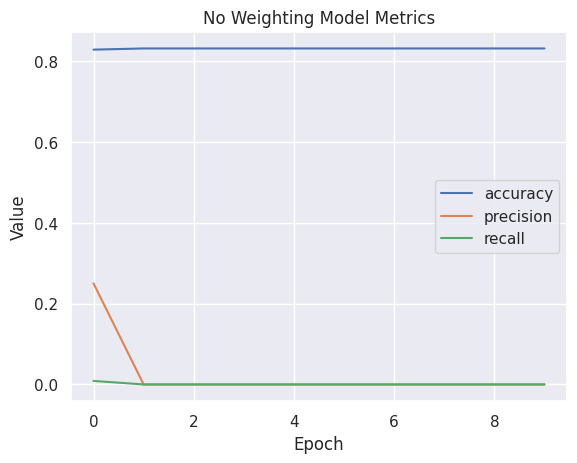

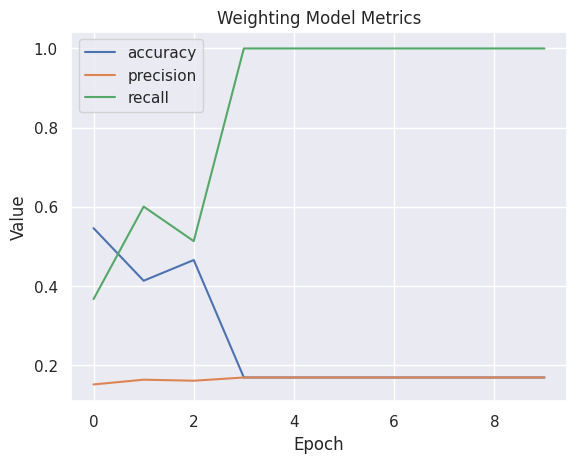

ValueError: Found input variables with inconsistent numbers of samples: [420, 4]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


best_model = tuner.get_best_models()[0]
best_model_weighted = weighted_tuner.get_best_models()[0]

no_weighting_results = best_model.evaluate(test)
no_weighting_predictions = best_model.predict(test)

weighting_predictions = best_model_weighted.predict(test)
weighting_predictions = best_model_weighted.evaluate(test)

sns.set_theme("notebook")

true_y = np.concatenate([y for _, y in test], axis=0).astype(int)
weighted_output = (np.array(weighting_predictions) > 0.5).astype(int)
no_weighting_output = (np.array(no_weighting_predictions) > 0.5).astype(int)

# plot the metrics using seaborn
def plot_metrics(history, metrics, title=None):
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend()
    plt.show()

plot_metrics(no_weighting_history, ['accuracy', 'precision', 'recall'], title="No Weighting Model Metrics")
plot_metrics(weighting_history, ['accuracy', 'precision', 'recall'], title="Weighting Model Metrics")

def plot_confusion_matrix(y_true, y_pred, classes, title=None, cmap=plt.cm.Blues):
    matrix = confusion_matrix(y_true, y_pred)
    sns.heatmap(matrix, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Class', fontsize=10)
    plt.ylabel('Actual Class', fontsize=10)
    plt.title(title, fontsize=12)
    plt.show()

plot_confusion_matrix(true_y, weighted_output, ['normal', 'tuberculosis'], title='Confusion Matrix for Weighted Model')
plot_confusion_matrix(true_y, no_weighting_output, ['normal', 'tuberculosis'], title='Confusion Matrix for No Weighting Model')